# 一、数据校验
首先需要检查诊断数据，如果显示检查通过！择可以正常运行之后的，否则请根据提示调整数据。

数据文件中的数据都是数值类型，或者可以映射成数值类型，这里的label某些情况下可能是非数值的，需要自定义数值函数。

注意：在使用树模型时，可以存在缺失，但是线性模型不允许缺失，请自行根据需要填充缺省值

In [1]:
from collections import namedtuple
import onekey_algo.custom.components as okcomp
from onekey_algo import OnekeyDS as okds

import pandas as pd
import numpy as np

# 读取数据，B超诊断阳性=1，bc_data.csv是要读取的数据。
data_file = "./merged_rad_label.csv"
labels = ['label']
featrues_not_use = ['ID']

data = pd.read_csv(data_file, header=0)
data.head()

,ID,group,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,001chenbixia.nii.gz,train,0,-251.609299,127.512519,4.800978e+08,6.859410,192.277244,3.255328,522.652222,...,0.000188,0.000175,5622.181326,0.895822,0.957595,217552.03420,0.000174,9.467334,0.935320,0.113446
1,002youhongliying.nii.gz,train,0,-163.753589,29.240735,2.870217e+08,5.897227,106.021313,2.581645,139.524674,...,0.000275,0.000267,3767.890828,0.842929,0.934489,58417.60669,0.000266,8.429502,0.907614,0.137514
2,002zuohongliying.nii.gz,train,0,-202.519995,-12.366472,3.268286e+07,5.761232,97.881493,2.718540,87.125214,...,0.001313,0.001306,672.104592,0.857276,0.941123,45205.90438,0.001305,7.757620,0.919109,0.105775
3,003chensuduan.nii.gz,train,1,-219.458572,42.604574,3.638395e+07,6.232228,152.380772,2.466881,188.556747,...,0.002251,0.002082,539.116667,0.898528,0.959225,56529.10620,0.002045,8.195708,0.943396,0.073067
4,004guomeifang.nii.gz,train,1,-245.550147,17.924065,2.310635e+08,6.374907,140.638416,2.868257,243.387680,...,0.000314,0.000311,4185.728408,0.901514,0.960553,109190.17880,0.000310,9.102329,0.946199,0.064826


In [2]:
label_data=data[['ID','label']]
label_data

,ID,label
0,001chenbixia.nii.gz,0
1,002youhongliying.nii.gz,0
2,002zuohongliying.nii.gz,0
3,003chensuduan.nii.gz,1
4,004guomeifang.nii.gz,1
...,...,...
627,WuShuQiong-MR030602-20230708.nii.gz,0
628,xiesiyuan-MR039125.nii.gz,1
629,xushuping-MR036580.nii.gz,1
630,XuYuMei-MR034053-20231016.nii.gz,0


In [3]:
# Split the dataset using the index numbers based on the 'group' column
train_indices = data[data['group'] == 'train'].index
test_indices = data[data['group'] == 'test'].index
train_indices
# # Split the data based on these index numbers
# X_train_by_index = data.loc[train_indices, 'ID']
# y_train_by_index = data.loc[train_indices, 'label']
# X_test_by_index = data.loc[test_indices, 'ID']
# y_test_by_index = data.loc[test_indices, 'label']

# # Display the first few entries from the train and test sets
# X_train_by_index.head(), X_test_by_index.head()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,  10,  11,
            ...
            618, 619, 620, 622, 623, 624, 627, 629, 630, 631],
           dtype='int64', length=444)

## 特征维度

In [4]:
# 删掉ID这一列。
ids = data['ID']
group=data['group']
structed_data = data.drop(['ID','group'], axis=1)
structed_data.columns

Index(['label', 'log-sigma-2-0-mm-3D_firstorder_10Percentile',
       'log-sigma-2-0-mm-3D_firstorder_90Percentile',
       'log-sigma-2-0-mm-3D_firstorder_Energy',
       'log-sigma-2-0-mm-3D_firstorder_Entropy',
       'log-sigma-2-0-mm-3D_firstorder_InterquartileRange',
       'log-sigma-2-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-2-0-mm-3D_firstorder_Maximum',
       'log-sigma-2-0-mm-3D_firstorder_Mean',
       'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation',
       ...
       'wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LLL_glszm_SizeZoneNonUniformity',
       'wavelet-LLL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-LLL_glszm_SmallAreaEmphasis',
       'wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZonePercentage',
       'wavelet-LLL_glszm_ZoneVariance'],
     

## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [5]:
structed_data.describe()

,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
count,632.000000,632.000000,632.000000,6.320000e+02,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,0.134494,-249.218675,-23.169759,2.303883e+08,5.963793,123.772086,2.823596,119.407313,-135.742059,70.756587,...,0.000826,0.000775,3287.085433,0.849167,0.936400,83298.220923,0.000765,8.475645,0.910348,0.145033
std,0.341452,108.296964,54.792378,5.133871e+08,0.585092,54.938505,0.714220,112.523099,68.954702,30.176922,...,0.000931,0.000893,4627.512977,0.056622,0.027174,74986.854712,0.000894,0.531153,0.040818,0.125465
min,0.000000,-735.930835,-236.250873,1.589622e+06,3.646471,18.409405,1.879963,-117.514420,-463.971035,12.312143,...,0.000048,0.000043,114.150000,0.576390,0.787710,2939.448668,0.000042,6.633933,0.677313,0.019020
25%,0.000000,-305.853289,-56.437886,4.190928e+07,5.621433,86.914244,2.435764,49.815005,-179.377069,50.539934,...,0.000294,0.000282,1138.570390,0.819901,0.923714,35556.075193,0.000273,8.127084,0.891290,0.079250
50%,0.000000,-233.265954,-17.835919,1.016311e+08,5.995283,114.030945,2.699168,92.887161,-123.947250,65.736333,...,0.000531,0.000491,2135.079242,0.857202,0.941000,61881.795565,0.000467,8.478710,0.917605,0.115031
75%,0.000000,-173.945952,7.786506,2.403653e+08,6.322289,148.126786,3.013870,166.249809,-83.893078,84.463399,...,0.000924,0.000882,3977.040385,0.886589,0.954052,102442.193950,0.000872,8.797007,0.936760,0.167422
max,1.000000,-31.671468,239.725861,8.490677e+09,7.538923,349.100166,8.988884,738.653503,0.987394,192.306078,...,0.008409,0.008407,60733.779440,0.961959,0.985453,589014.914100,0.008406,10.051940,0.980973,1.226989


## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [6]:
# #z-score标准化
# from sklearn.preprocessing import StandardScaler
# Stan_scaler = StandardScaler()
# x_st_nom = Stan_scaler.fit_transform(data.iloc[:,1:-1])
# x_st_nom
# # x_xah_nom=Stan_scaler.transform(x_xah)
# data_nom=pd.DataFrame(x_st_nom)
# data_nom.columns=data.columns[1:-1]
# structed_data = pd.merge(label_data,data_nom,left_index=True,right_index=True, how='inner')
# structed_data

In [7]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(structed_data, not_norm=labels)
data = data.dropna(axis=1)
data

,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,0,-0.022075,2.750059,0.486396,1.530730,1.246943,0.604481,3.583663,0.843773,1.532183,...,-0.685886,-0.671654,0.504611,0.823991,0.779999,1.790365,-0.661458,1.867049,0.611793,-0.251762
1,0,0.789173,0.956529,0.110313,-0.113769,-0.323103,-0.338762,0.178784,0.952692,-0.355272,...,-0.592335,-0.568864,0.103901,-0.110172,-0.070311,-0.331800,-0.558692,-0.086874,-0.066986,-0.059936
2,0,0.431210,0.197168,-0.385100,-0.346204,-0.471265,-0.147092,-0.286893,0.263960,-0.444144,...,0.522539,0.594108,-0.565094,0.143224,0.173806,-0.507987,0.603340,-1.351823,0.214628,-0.312906
3,1,0.274801,1.200429,-0.377891,0.458792,0.520740,-0.499447,0.614535,0.757072,0.449592,...,1.529160,1.462530,-0.593833,0.871771,0.839956,-0.356984,1.431923,-0.527037,0.809644,-0.573599
4,1,0.033875,0.749992,0.001315,0.702649,0.307004,0.062532,1.101821,0.393094,0.382856,...,-0.550260,-0.520044,0.194196,0.924507,0.888841,0.345287,-0.509058,1.179856,0.878317,-0.639277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,0,0.623529,1.174706,1.126001,0.293625,-0.116383,-0.020615,0.957375,0.931365,-0.062351,...,-0.782534,-0.761429,1.593388,0.126592,0.155004,0.831477,-0.750103,1.311692,0.160957,-0.223910
628,1,-0.122869,1.359435,0.912719,1.111134,0.774631,0.098006,1.017467,0.497795,0.873519,...,-0.761510,-0.740763,1.645121,0.783119,0.765126,0.417398,-0.729773,1.459766,0.770282,-0.582710
629,1,-1.723255,-0.131894,-0.311432,1.593615,1.532990,-0.251277,0.469896,-1.207338,1.736445,...,-0.341222,-0.305478,-0.243639,1.673090,1.537644,1.233990,-0.295649,1.575587,1.479189,-0.901948
630,0,0.217090,0.601160,-0.308844,0.348826,0.050563,0.096317,0.123983,0.475666,0.086328,...,-0.046530,0.002549,-0.437844,0.608865,0.609805,-0.254832,0.012550,0.211960,0.652121,-0.566475


# 统计检验

通过ttest或者utest进行特征筛选。

注意 ：此步骤不是论文的标配，所以用不用在自己的选择，可以通过修改pvalue的值进行调整，默认是0.05为显著。

In [8]:
import seaborn as sns
from onekey_algo.custom.components.stats import clinic_stats

stats = clinic_stats(data, stats_columns=list(data.columns[1:]), label_column=labels[0], 
                     continuous_columns=list(data.columns[1:]))
stats.to_csv(f'results/pvalue.csv', index=False)
stats

Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttes

Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttes

Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...
Using ttest...


,feature_name,-label=ALL,-label=0,-label=1,pvalue
0,log-sigma-2-0-mm-3D_firstorder_10Percentile,-0.0000±1.0000,-0.0259±1.0097,0.1665±0.9237,0.098942
1,log-sigma-2-0-mm-3D_firstorder_90Percentile,-0.0000±1.0000,-0.0497±1.0133,0.3198±0.8476,0.001484
2,log-sigma-2-0-mm-3D_firstorder_Energy,-0.0000±1.0000,-0.0579±0.9233,0.3728±1.3447,0.000207
3,log-sigma-2-0-mm-3D_firstorder_Entropy,-0.0000±1.0000,-0.0083±0.9939,0.0533±1.0430,0.597469
4,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,0.0000±1.0000,0.0080±1.0105,-0.0517±0.9335,0.608848
...,...,...,...,...,...
1127,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,-0.0000±1.0000,-0.0033±0.9849,0.0212±1.0984,0.834013
1128,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,0.0000±1.0000,0.0524±1.0459,-0.3374±0.5177,0.000796
1129,wavelet-LLL_glszm_ZoneEntropy,0.0000±1.0000,-0.0380±1.0044,0.2445±0.9408,0.015259
1130,wavelet-LLL_glszm_ZonePercentage,-0.0000±1.0000,-0.0056±0.9842,0.0358±1.1017,0.723198


In [9]:
import matplotlib.pyplot as plt
stats[['pvalue']] = stats[['pvalue']].applymap(lambda x: float(str(x)[1:]))
# stats[['group']] = stats[['feature_name']].applymap(lambda x: x.split('_')[1])
# stats = stats[['feature_name', 'pvalue', 'group']]
# g = sns.catplot(x="group", y="pvalue", data=stats, kind="box")
# g.fig.set_size_inches(15,10)
# sns.stripplot(x="group", y="pvalue", data=stats, ax=g.ax, color='black')
# plt.savefig(f'img/feature_stats.tif', bbox_inches = 'tight')

调整pvalue进行筛选

In [10]:
pvalue = 0.1
sel_feature = list(stats[stats['pvalue'] < 0.1]['feature_name']) + labels
data = data[sel_feature]

data.to_csv(f'results/pvalue_sel_feature.csv', index=False)
data

,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_Median,log-sigma-2-0-mm-3D_firstorder_Range,log-sigma-2-0-mm-3D_firstorder_RootMeanSquared,log-sigma-2-0-mm-3D_firstorder_Skewness,...,wavelet-LLL_glrlm_RunLengthNonUniformity,wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-LLL_glszm_GrayLevelNonUniformity,wavelet-LLL_glszm_GrayLevelNonUniformityNormalized,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,label
0,-0.022075,2.750059,0.486396,0.604481,3.583663,0.843773,0.601247,2.034765,1.594528,1.763871,...,0.392552,-0.663504,-0.170849,-1.326315,-0.685886,-0.671654,0.504611,-0.661458,1.867049,0
1,0.789173,0.956529,0.110313,-0.338762,0.178784,0.952692,0.933036,-0.340884,1.007305,0.398095,...,0.095623,-0.570241,0.297410,0.023568,-0.592335,-0.568864,0.103901,-0.558692,-0.086874,0
2,0.431210,0.197168,-0.385100,-0.147092,-0.286893,0.263960,0.110335,-0.675622,-0.021013,1.222207,...,-0.565802,0.569279,-0.568610,1.013137,0.522539,0.594108,-0.565094,0.603340,-1.351823,0
3,0.274801,1.200429,-0.377891,-0.499447,0.614535,0.757072,0.773495,0.016297,0.957121,0.007291,...,-0.600720,1.522789,-0.713697,-0.157823,1.529160,1.462530,-0.593833,1.431923,-0.527037,1
4,0.033875,0.749992,0.001315,0.062532,1.101821,0.393094,0.448245,0.591264,0.457633,-0.024427,...,0.100258,-0.511019,-0.229197,-1.091854,-0.550260,-0.520044,0.194196,-0.509058,1.179856,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,0.623529,1.174706,1.126001,-0.020615,0.957375,0.931365,0.908076,0.236827,1.066124,0.338325,...,1.507004,-0.756661,1.058336,-0.922373,-0.782534,-0.761429,1.593388,-0.750103,1.311692,0
628,-0.122869,1.359435,0.912719,0.098006,1.017467,0.497795,0.616782,1.453803,0.802105,-0.819976,...,1.418631,-0.732982,0.698368,-1.161303,-0.761510,-0.740763,1.645121,-0.729773,1.459766,1
629,-1.723255,-0.131894,-0.311432,-0.251277,0.469896,-1.207338,-1.036233,1.303817,-0.534222,-0.785458,...,-0.315830,-0.281057,-0.603768,-1.315117,-0.341222,-0.305478,-0.243639,-0.295649,1.575587,1
630,0.217090,0.601160,-0.308844,0.096317,0.123983,0.475666,0.583312,0.034795,0.461576,-0.955778,...,-0.455485,0.006258,-0.569867,-0.495331,-0.046530,0.002549,-0.437844,0.012550,0.211960,0


In [11]:
data = data[sel_feature]
data.describe()

,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_Median,log-sigma-2-0-mm-3D_firstorder_Range,log-sigma-2-0-mm-3D_firstorder_RootMeanSquared,log-sigma-2-0-mm-3D_firstorder_Skewness,...,wavelet-LLL_glrlm_RunLengthNonUniformity,wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-LLL_glszm_GrayLevelNonUniformity,wavelet-LLL_glszm_GrayLevelNonUniformityNormalized,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,label
count,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,...,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,6.320000e+02,632.000000
mean,-2.360981e-16,-2.248553e-17,-3.653899e-17,8.010470e-17,-1.911270e-16,-8.994212e-17,2.248553e-17,-2.023698e-16,-2.079911e-16,5.621382e-18,...,1.517773e-16,-8.432074e-17,8.713143e-17,2.417194e-16,1.096170e-16,-3.653899e-17,-9.556350e-17,6.745659e-17,9.275281e-16,0.134494
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.341452
min,-4.494236e+00,-3.888882e+00,-4.456650e-01,-1.321207e+00,-2.105539e+00,-4.760067e+00,-4.617337e+00,-1.752149e+00,-2.695588e+00,-3.172852e+00,...,-6.846055e-01,-8.123678e-01,-7.803544e-01,-1.713569e+00,-8.363239e-01,-8.204357e-01,-6.856675e-01,-8.096237e-01,-3.467384e+00,0.000000
25%,-5.229566e-01,-6.071670e-01,-3.671284e-01,-5.430142e-01,-6.184713e-01,-6.328069e-01,-6.383452e-01,-6.959795e-01,-8.092535e-01,-5.793793e-01,...,-4.685212e-01,-5.503559e-01,-5.413079e-01,-6.663225e-01,-5.713477e-01,-5.523677e-01,-4.642915e-01,-5.505278e-01,-6.562344e-01,0.000000
50%,1.473053e-01,9.734638e-02,-2.507994e-01,-1.742140e-01,-2.356863e-01,1.710516e-01,1.421144e-01,-1.951567e-01,6.591658e-02,-3.066318e-02,...,-2.641770e-01,-3.296468e-01,-2.727146e-01,-1.679071e-01,-3.173722e-01,-3.184833e-01,-2.489472e-01,-3.341593e-01,5.769348e-03,0.000000
75%,6.950585e-01,5.649739e-01,1.943364e-02,2.664080e-01,4.162923e-01,7.519281e-01,7.249144e-01,4.780235e-01,7.163769e-01,4.377501e-01,...,1.304725e-01,1.080345e-01,1.570727e-01,4.230677e-01,1.044846e-01,1.198260e-01,1.490984e-01,1.198973e-01,6.050263e-01,0.000000
max,2.008802e+00,4.798033e+00,1.608979e+01,8.632198e+00,5.503281e+00,1.982888e+00,2.087820e+00,4.880228e+00,2.757857e+00,4.948689e+00,...,1.273755e+01,8.858129e+00,9.595520e+00,5.998905e+00,8.140697e+00,8.544746e+00,1.241416e+01,8.548961e+00,2.967683e+00,1.000000


## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [12]:
#仅用t-test时
sel_data = data

In [13]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 2
y_data = sel_data[labels]
X_data = sel_data.drop(labels, axis=1)
column_names = X_data.columns

X_train, X_test, y_train, y_test = okcomp.comp1.split_dataset(X_data, y_data, test_size=0.3, random_state=0)
print(f"训练集样本数：{X_train.shape}, 验证集样本数：{X_test.shape}")

训练集样本数：(442, 615), 验证集样本数：(190, 615)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

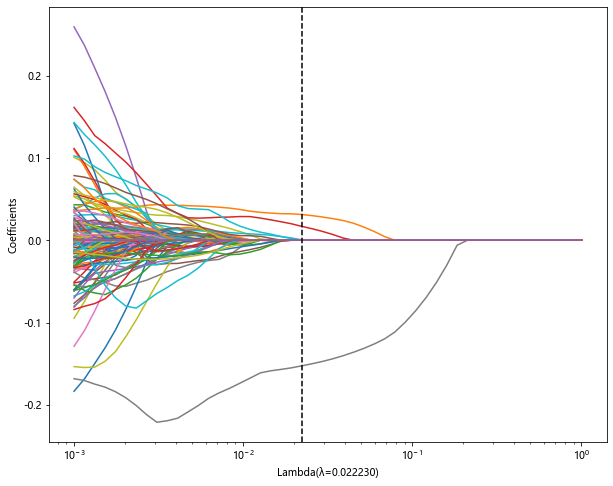

In [14]:
import matplotlib.pyplot as plt
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data,column_names=None)
plt.savefig(f'img/feature_lasso.tif', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

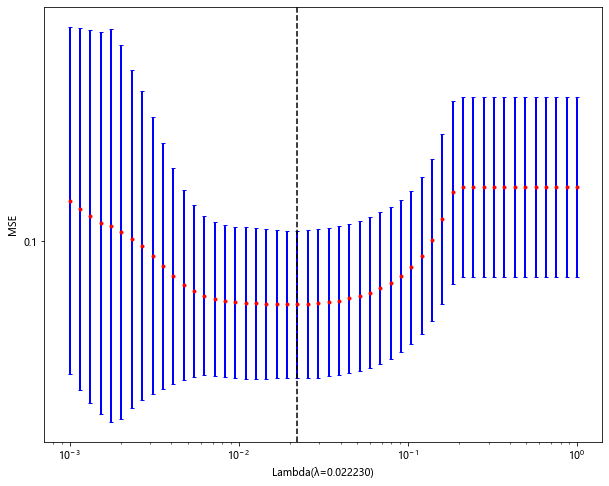

In [15]:
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50)
plt.savefig(f'img/feature_mse.tif', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [16]:
from sklearn import linear_model

models = []
for label in labels:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, y_train[label])
    models.append(clf)

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [17]:
COEF_THRESHOLD = 1e-6 # 筛选的特征阈值
scores = []
selected_features = []
for label, model in zip(labels, models):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
print(scores[0])

label = 0.13691476462196228 + +0.008518 * original_shape_Maximum2DDiameterColumn -0.161045 * original_shape_Sphericity +0.004767 * original_shape_SurfaceArea +0.005657 * wavelet-HHL_firstorder_RootMeanSquared +0.000760 * wavelet-HLH_glszm_ZoneEntropy -0.000637 * wavelet-HLL_glcm_Correlation +0.025392 * wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis +0.003111 * wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis


In [18]:
with open('results/scores.txt','w') as f:
    f.write(scores[0])

### 特征权重

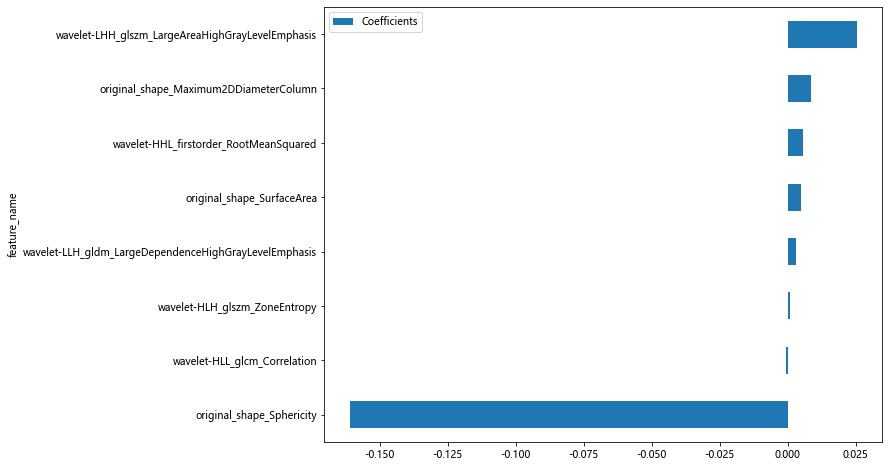

In [19]:
feat_coef = sorted(feat_coef, key=lambda x: x[1])
feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')
feat_coef_df.to_csv(f'results/lasso_sel_feature.csv', index=False)
plt.savefig(f'img/feature_weights.tif', bbox_inches = 'tight')

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [20]:
X_data = X_data[selected_features[0]]
X_data.columns

Index(['original_shape_Maximum2DDiameterColumn', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_ZoneEntropy', 'wavelet-HLL_glcm_Correlation',
       'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis'],
      dtype='object')

In [21]:
# Split the data based on these index numbers
X_train_sel = X_data.loc[train_indices]
y_train_sel = y_data.loc[train_indices]
X_test_sel = X_data.loc[test_indices]
y_test_sel = y_data.loc[test_indices]
X_train_sel.head(), X_test_sel.head()

(   original_shape_Maximum2DDiameterColumn  original_shape_Sphericity  \
 0                                0.935035                  -0.621301   
 1                                0.886184                  -0.162656   
 2                               -0.484615                  -0.240182   
 3                                0.048451                  -2.101186   
 4                                0.554912                  -2.388896   
 
    original_shape_SurfaceArea  wavelet-HHL_firstorder_RootMeanSquared  \
 0                    1.256998                                0.686602   
 1                    0.699392                               -0.582220   
 2                   -0.481711                               -0.425569   
 3                   -0.404736                                0.752147   
 4                    1.612348                                0.192336   
 
    wavelet-HLH_glszm_ZoneEntropy  wavelet-HLL_glcm_Correlation  \
 0                       1.559919              

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [22]:
model_names = ['SVM', 'KNN',  'RandomForest', 'ExtraTrees', 'XGBoost','MLP','LR']
models = okcomp.comp1.create_clf_model(model_names)
model_names = list(models.keys())
model_names

['SVM', 'KNN', 'RandomForest', 'ExtraTrees', 'XGBoost', 'MLP', 'LR']

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [23]:
import os
import joblib
# from onekey_algo.custom.components.comp1 import plot_feature_importance
targets = []
os.makedirs('models', exist_ok=True)
for l in labels:
    new_models = list(okcomp.comp1.create_clf_model(model_names).values())
    for mn, m in zip(model_names, new_models):
        m.fit(X_train_sel, y_train_sel[l])
        # 保存训练的模型
        joblib.dump(m, f'models/Rad_{mn}_{l}.pkl') 
        # 输出模型特征重要性，只针对高级树模型有用
#         plot_feature_importance(m, selected_features[0], save_dir='img')
    targets.append(new_models)


## 预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-train"))
                 
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_test_sel[label], 
                                                                                              test_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-test"))
        # 计算thres对应的sel idx
        pred_sel_idx_label.append(np.logical_or(test_score[:, 0] >= thres, test_score[:, 1] >= thres))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 
                                                   'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Task'])
metric.to_csv(f'results/metric_acc_auc_etal.csv', index=False)
metric

,model_name,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Task
0,SVM,0.912162,0.912023,0.8565 - 0.9676,0.883333,0.916667,0.623529,0.980501,0.623529,0.883333,0.731034,0.085919,label-train
1,SVM,0.824468,0.834601,0.7271 - 0.9421,0.840000,0.822086,0.420000,0.971014,0.420000,0.840000,0.560000,0.087202,label-test
2,KNN,0.815315,0.945182,0.9255 - 0.9649,1.000000,0.786458,0.422535,1.000000,0.422535,1.000000,0.594059,0.200000,label-train
3,KNN,0.845745,0.721350,0.6025 - 0.8402,0.520000,0.895706,0.433333,0.924051,0.433333,0.520000,0.472727,0.400000,label-test
4,RandomForest,0.990991,0.999740,0.9994 - 1.0000,1.000000,0.989583,0.937500,1.000000,0.937500,1.000000,0.967742,0.400000,label-train
5,RandomForest,0.675532,0.841227,0.7587 - 0.9238,0.920000,0.638037,0.280488,0.981132,0.280488,0.920000,0.429907,0.100000,label-test
6,ExtraTrees,1.000000,1.000000,nan - nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,label-train
7,ExtraTrees,0.867021,0.809202,0.7025 - 0.9159,0.680000,0.901235,0.500000,0.948052,0.500000,0.680000,0.576271,0.300000,label-test
8,XGBoost,0.981982,0.995573,0.9899 - 1.0000,0.950000,0.986979,0.919355,0.992147,0.919355,0.950000,0.934426,0.315302,label-train
9,XGBoost,0.851064,0.855828,0.7755 - 0.9362,0.760000,0.865031,0.463415,0.959184,0.463415,0.760000,0.575758,0.188230,label-test


### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

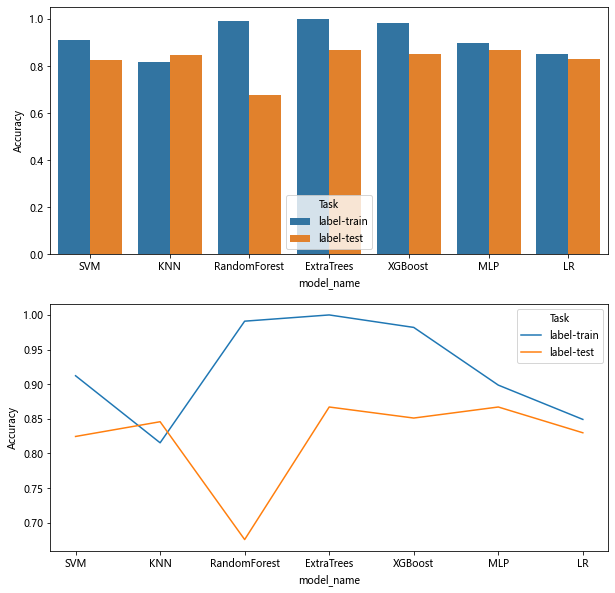

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/model_acc.tif', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

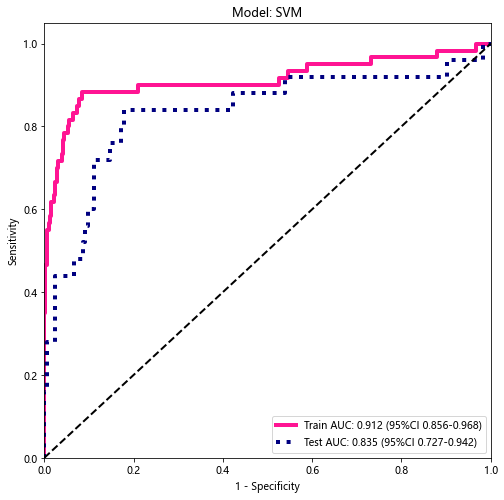

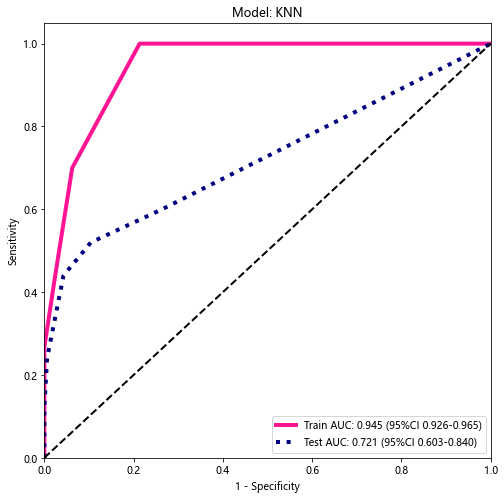

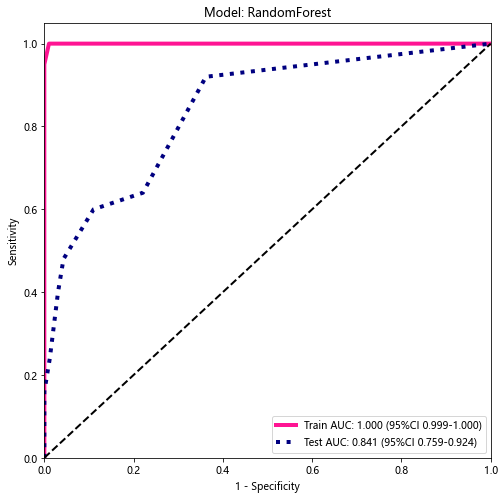

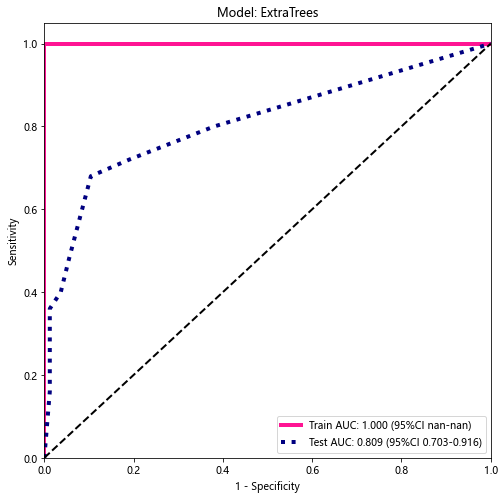

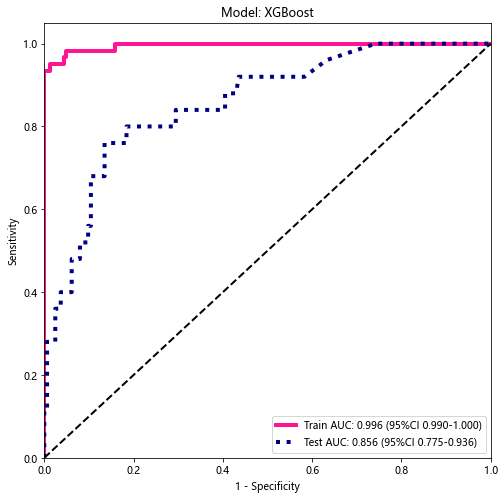

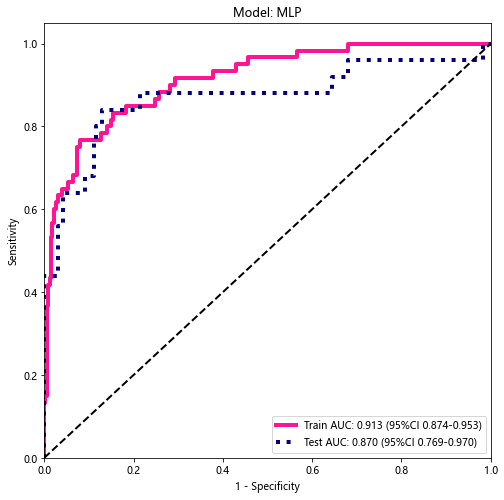

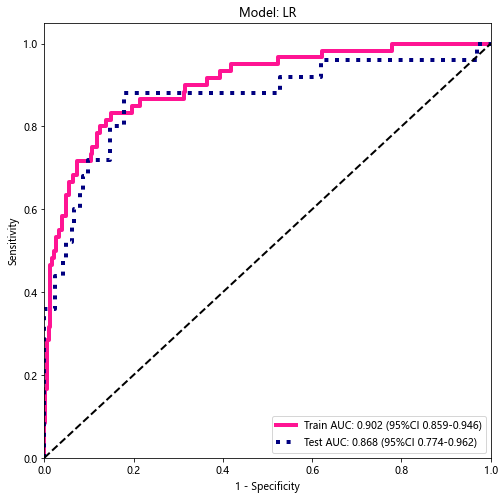

In [26]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc([np.array(y_train_sel[label]), np.array(y_test_sel[label])], 
                                  pred_score[sel_model_idx], 
                                  labels=['Train', 'Test'], title=f"Model: {sm}")
            plt.savefig(f'img/model_{sm}_roc.tif', bbox_inches = 'tight')

#### 汇总所有模型

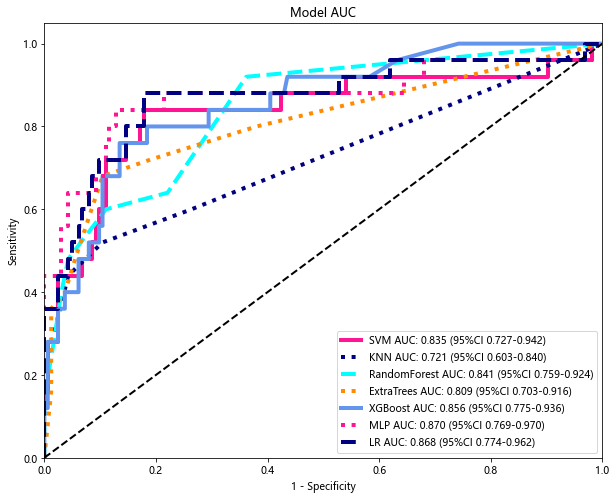

In [27]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][1])
    okcomp.comp1.draw_roc([np.array(y_test_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/model_roc.tif', bbox_inches = 'tight')

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [28]:
import os
import numpy as np

os.makedirs('results', exist_ok=True)
sel_model = model_names

for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(ids.loc[list(X_train_sel.index)]), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(ids.loc[list(X_test_sel.index)]), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'results/Rad_{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'results/Rad_{sm}_test.csv', index=False)

In [29]:
# 设置绘制参数
sel_model = 'MLP'
c_matrix = {}

sel_model_idx = model_names.index(sel_model)
for idx, label in enumerate(labels):
    y_train_gt=y_train_sel[label]
#     print(y_train_gt)
    y_test_gt=y_test_sel[label]
#     print(y_test_gt)


In [30]:
df_train = pd.read_csv('./results/Rad_MLP_train.csv')
train_score= df_train['label-1'].values
# train_score

In [31]:
thre_mlp_train= 0.200816
y_pred_mlp_train = np.array(train_score>= thre_mlp_train).astype(int)
y_pred_mlp_train

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [32]:
df_test = pd.read_csv('./results/Rad_MLP_test.csv')
test_score= df_test['label-1'].values

In [33]:
thre_mlp_test=0.147410
y_pred_mlp_test = np.array(test_score>= thre_mlp_test).astype(int)
y_pred_mlp_test

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1])

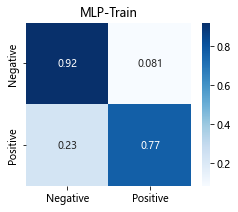

In [34]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred_mlp_train,y_train_gt,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'MLP-Train')
okcomp.comp1.draw_matrix(cm, norm=True, annot=True, cmap='Blues')
plt.savefig(f'img/MLP-Train-CM.tif.tif', bbox_inches = 'tight',dpi=300)

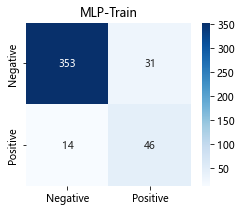

In [35]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred_mlp_train,y_train_gt,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'MLP-Train')
okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues')
plt.savefig(f'img/MLP-Train-CM1.tif.tif', bbox_inches = 'tight',dpi=300)

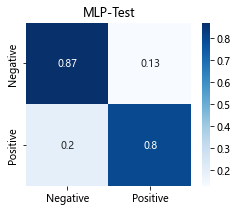

In [36]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred_mlp_test,y_test_gt,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'MLP-Test')
okcomp.comp1.draw_matrix(cm, norm=True, annot=True, cmap='Blues')
plt.savefig(f'img/MLP-Test-CM.tif.tif', bbox_inches = 'tight',dpi=300)

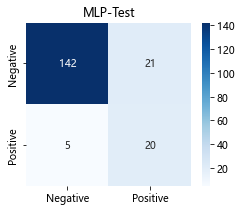

In [37]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred_mlp_test,y_test_gt,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'MLP-Test')
okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues')
plt.savefig(f'img/MLP-Test-CM1.tif.tif', bbox_inches = 'tight',dpi=300)

In [20]:
st_file = "./test_st_radio.csv"
data_st = pd.read_csv(st_file, header=0)
labels_st = ['label']
featrues_not_use = ['ID']
label_st_data=data_st[['ID','label']]

In [21]:
ids_st = data_st['ID']
structed_data_st = data_st.drop(['ID'], axis=1)
structed_data_st.columns

Index(['label', 'log-sigma-2-0-mm-3D_firstorder_10Percentile',
       'log-sigma-2-0-mm-3D_firstorder_90Percentile',
       'log-sigma-2-0-mm-3D_firstorder_Energy',
       'log-sigma-2-0-mm-3D_firstorder_Entropy',
       'log-sigma-2-0-mm-3D_firstorder_InterquartileRange',
       'log-sigma-2-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-2-0-mm-3D_firstorder_Maximum',
       'log-sigma-2-0-mm-3D_firstorder_Mean',
       'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation',
       ...
       'M', 'clinical_grade', 'molecular_type', 'NAC', 'locate', 'Path class',
       'IDC stage', 'DCIS stage', 'doctor', 'doctor_level'],
      dtype='object', length=1173)

In [22]:
from onekey_algo.custom.components.comp1 import normalize_df
data_st = normalize_df(structed_data_st, not_norm=labels_st)
data_st = data_st.dropna(axis=1)
data_st

,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,...,M,clinical_grade,molecular_type,NAC,locate,Path class,IDC stage,DCIS stage,doctor,doctor_level
0,0,-1.047822,-1.002934,-0.475114,0.930937,0.163235,3.996325,1.859915,-1.465651,0.683874,...,-0.072548,-0.643341,-0.316505,-0.222401,-1.029374,-0.725548,0.712921,-0.603961,-0.460526,-0.479161
1,0,0.694507,1.874681,2.381733,0.663100,0.247502,0.268076,1.514016,1.306012,0.313661,...,-0.072548,1.344217,0.567848,-0.222401,0.966351,-0.725548,0.712921,-0.603961,-0.460526,-0.479161
2,0,0.275267,0.218230,-0.401791,0.093604,-0.176787,-0.101180,-0.326642,0.249309,-0.143243,...,-0.072548,0.350438,-1.200858,-0.222401,0.966351,-0.725548,-0.337118,-0.603961,-0.460526,-0.479161
3,0,-0.285909,-0.272823,-0.350643,0.381483,-0.062174,0.662398,0.350979,-0.527185,0.149735,...,-0.072548,1.344217,-0.316505,-0.222401,-1.029374,-0.725548,0.712921,-0.603961,-0.460526,-0.479161
4,0,-0.156667,0.819938,-0.549444,0.671319,1.110555,-1.250178,-0.151782,0.246138,0.835028,...,-0.072548,-0.643341,-1.200858,-0.222401,0.966351,-0.725548,-0.337118,-0.603961,-0.460526,-0.479161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1,-1.762519,-1.367575,-0.515198,1.218292,1.035475,-0.379921,0.018281,-1.951142,1.068185,...,-0.072548,-0.643341,0.567848,-0.222401,0.966351,1.202481,0.712921,1.872714,-0.460526,-0.479161
186,1,0.472972,-0.237226,0.140532,-0.509221,-0.555203,-0.342166,-0.084613,0.273615,-0.607830,...,-0.072548,-0.643341,1.452201,-0.222401,0.966351,1.202481,0.712921,1.872714,-0.460526,-0.479161
187,0,-0.964605,1.000948,0.243697,1.733975,1.281456,2.446830,3.165422,-0.194683,1.627312,...,-0.072548,0.350438,-0.316505,-0.222401,-1.029374,1.202481,0.712921,1.872714,0.721906,1.305949
188,1,0.785070,0.786244,0.012835,-0.182963,-0.597124,0.688147,0.465751,0.975760,-0.463615,...,-0.072548,-0.643341,-0.316505,-0.222401,0.966351,1.202481,0.712921,1.872714,-0.460526,-0.479161


In [23]:
y_st_data = data_st[labels]
X_st_data = data_st.drop(labels, axis=1)

In [24]:
X_st_data = X_st_data[selected_features[0]]
X_st_data.columns

Index(['original_shape_Maximum2DDiameterColumn', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_ZoneEntropy', 'wavelet-HLL_glcm_Correlation',
       'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis'],
      dtype='object')

In [25]:
import joblib
model_bst=joblib.load('./models/Rad_MLP_label.pkl')
model_bst

MLPClassifier(hidden_layer_sizes=(128, 128, 64), max_iter=1000, random_state=0,
              solver='sgd')

In [26]:
y_stall_score=model_bst.predict_proba(X_st_data)


from onekey_algo.custom.components.metrics import analysis_pred_binary
acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres= analysis_pred_binary(y_st_data, y_stall_score)
ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
metric_st = []
metric_st.append((acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres))
metric_st = pd.DataFrame(metric_st, index=None, columns=['Accuracy', 'AUC', '95% CI',
                                           'Sensitivity', 'Specificity', 
                                           'PPV', 'NPV', 'Precision', 'Recall', 'F1','Threshold'])
metric_st.to_csv(f'test_results/st_base_mmrm_metric.csv', index=False)
metric_st

In [27]:
# 预测训练集和测试集数据。
st_indexes = np.reshape(np.array(ids_st .loc[list(X_st_data.index)]), (-1, 1)).astype(str)
# y_xah_pred_scores = target.predict_proba(X_xah_data)
columns = ['ID'] + [f"{label}-{i}"for i in range(y_stall_score.shape[1])]
# 保存预测的训练集和测试集结果
result_train = pd.DataFrame(np.concatenate([st_indexes, y_stall_score], axis=1), columns=columns)
result_train.to_csv(f'test_results/Rad_test_st.csv', index=False)

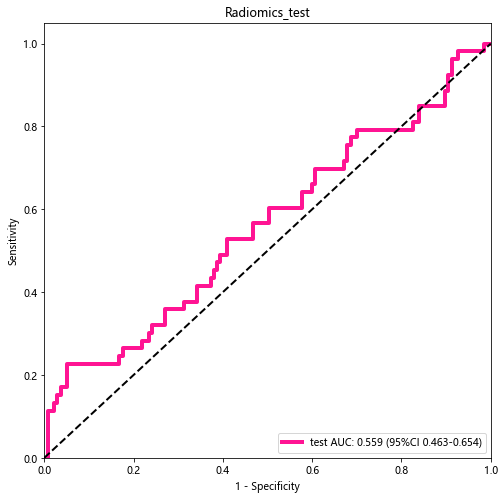

In [28]:
plt.figure(figsize=(8, 8))
# print(y_stall_score)
okcomp.comp1.draw_roc_test_only(y_st_data, y_stall_score[:,1], title='Radiomics_test')
plt.savefig(f'test_img/st_roc.tif', bbox_inches = 'tight')

from sklearn.metrics import roc_curve, auc
import numpy as np

fpr, tpr, thresholds = roc_curve(y_st_data, y_stall_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

In [29]:
y_pred = np.array(y_stall_score[:,-1] >= 0.147410).astype(int)
y_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_st_data, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6368421052631579


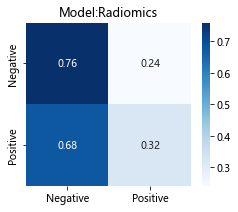

In [31]:
cm_st = okcomp.comp1.calc_confusion_matrix(y_pred,y_st_data[label],class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Model:Radiomics')
okcomp.comp1.draw_matrix(cm_st, norm=True, annot=True, cmap='Blues')
plt.savefig(f'test_img/Radiomics_test_st.tif', bbox_inches = 'tight',dpi=300)

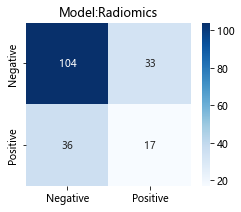

In [32]:
cm_st = okcomp.comp1.calc_confusion_matrix(y_pred,y_st_data[label],class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Model:Radiomics')
okcomp.comp1.draw_matrix(cm_st, norm=False, annot=True, cmap='Blues')
plt.savefig(f'test_img/Radiomics_test_st1.tif', bbox_inches = 'tight',dpi=300)

In [20]:
yz2024_file = "./yz2024_rad.csv"
data_yz2024 = pd.read_csv(yz2024_file, header=0)
labels_yz2024 = ['label']
featrues_not_use = ['ID']
label_yz2024_data=data_yz2024[['ID','label']]

In [21]:
ids_yz2024 = data_yz2024['ID']
structed_data_yz2024 = data_yz2024.drop(['ID'], axis=1)
structed_data_yz2024.columns

Index(['log-sigma-2-0-mm-3D_firstorder_10Percentile',
       'log-sigma-2-0-mm-3D_firstorder_90Percentile',
       'log-sigma-2-0-mm-3D_firstorder_Energy',
       'log-sigma-2-0-mm-3D_firstorder_Entropy',
       'log-sigma-2-0-mm-3D_firstorder_InterquartileRange',
       'log-sigma-2-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-2-0-mm-3D_firstorder_Maximum',
       'log-sigma-2-0-mm-3D_firstorder_Mean',
       'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation',
       'log-sigma-2-0-mm-3D_firstorder_Median',
       ...
       'wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LLL_glszm_SizeZoneNonUniformity',
       'wavelet-LLL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-LLL_glszm_SmallAreaEmphasis',
       'wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZonePercentage',
       'wavelet-LLL_glszm_ZoneVariance', 'label'],
      dtype='ob

In [22]:
from onekey_algo.custom.components.comp1 import normalize_df
data_yz2024= normalize_df(structed_data_yz2024, not_norm=labels_yz2024)
data_yz2024 = data_yz2024.dropna(axis=1)
data_yz2024

,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,log-sigma-2-0-mm-3D_firstorder_Median,...,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,label
0,1.197508,1.043461,-0.627977,-1.056284,-0.724044,-0.737948,-0.213579,1.293977,-0.801079,1.369844,...,0.462584,-0.971630,-0.588663,-0.557393,-0.838003,0.461797,-1.253100,-0.407438,-0.005102,1
1,-2.764129,-1.308145,-0.718465,1.820375,3.287563,-0.867243,-1.068226,-2.260909,2.748803,-2.014133,...,0.169251,-0.855411,2.675419,2.513855,0.312016,0.172459,0.070381,2.397244,-1.700219,0
2,0.988675,0.574103,0.262930,-0.750443,-1.091539,2.584191,0.536398,0.962672,-0.851288,1.003252,...,-0.305873,0.008148,-0.700020,-0.681847,-0.633279,-0.303742,0.062958,-0.664461,0.528190,0
3,-0.039580,-1.385626,-0.846337,-2.620892,-1.350228,-0.676602,-1.638838,-0.682471,-1.213877,-0.782068,...,7.415084,-1.134680,1.124617,1.040582,-0.931091,7.416025,-4.177431,0.731358,-0.398272,0
4,0.377955,0.026380,-0.560413,-0.506909,-0.507292,-0.534958,-0.392977,0.228315,-0.546423,0.170791,...,-0.041727,-0.605583,0.238287,0.232967,-0.523647,-0.038803,0.000609,0.005272,0.408018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,-1.133318,-1.360340,-0.767599,0.686803,0.562426,-0.528744,-0.962671,-1.357927,0.502118,-1.352461,...,-0.088319,-0.738958,-0.280922,-0.264245,-0.018576,-0.084956,-0.089286,-0.253456,0.047579,0
63,0.615286,0.311019,-0.532289,-0.734885,-0.445300,-1.031130,-0.417552,0.557559,-0.572961,0.530008,...,0.022959,-0.729941,-0.791029,-0.846717,-0.690943,0.024206,-0.481643,-1.402647,2.280024,0
64,0.729277,0.260309,-0.526288,-1.030954,-0.778812,-0.498731,-0.453547,0.698139,-0.814913,0.793384,...,0.001931,-0.689161,1.061332,1.067708,-0.637350,0.004774,-0.492337,1.117489,-1.037059,1
65,0.724026,0.252867,-0.256195,-0.930142,-0.606650,-0.762260,-0.384904,0.553512,-0.723186,0.482966,...,-0.100078,-0.341336,-0.988329,-1.015408,-0.459801,-0.097205,0.079948,-1.233436,1.438996,0


In [23]:
y_yz2024_data = data_yz2024[labels]
X_yz2024_data = data_yz2024.drop(labels, axis=1)

In [24]:
X_yz2024_data = X_yz2024_data[selected_features[0]]
X_yz2024_data.columns

Index(['original_shape_Maximum2DDiameterColumn', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_ZoneEntropy', 'wavelet-HLL_glcm_Correlation',
       'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis'],
      dtype='object')

In [25]:
import joblib
model_bst=joblib.load('./models/Rad_MLP_label.pkl')
model_bst

MLPClassifier(hidden_layer_sizes=(128, 128, 64), max_iter=1000, random_state=0,
              solver='sgd')

In [26]:
y_yz2024_score=model_bst.predict_proba(X_yz2024_data)

In [27]:
# 预测训练集和测试集数据。
yz2024_indexes = np.reshape(np.array(ids_yz2024 .loc[list(X_yz2024_data.index)]), (-1, 1)).astype(str)
# y_xah_pred_scores = target.predict_proba(X_xah_data)
columns = ['ID'] + [f"{label}-{i}"for i in range(y_yz2024_score.shape[1])]
# 保存预测的训练集和测试集结果
result_yz2024 = pd.DataFrame(np.concatenate([yz2024_indexes, y_yz2024_score], axis=1), columns=columns)
result_yz2024.to_csv(f'test_results/Rad_test_yz2024.csv', index=False)

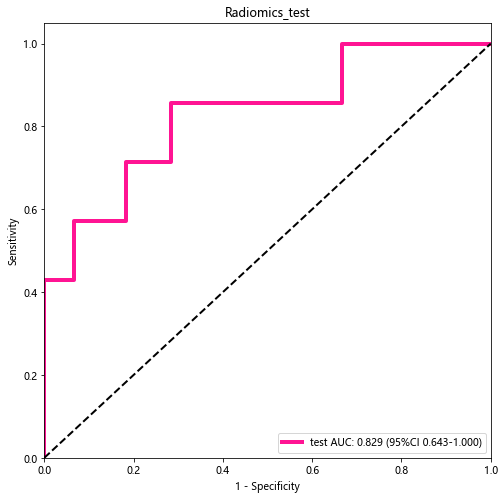

In [28]:
plt.figure(figsize=(8, 8))
# print(y_stall_score)
okcomp.comp1.draw_roc_test_only(y_yz2024_data, y_yz2024_score[:,1], title='Radiomics_test')
plt.savefig(f'test_img/yz2024_roc.tif', bbox_inches = 'tight')

In [29]:
y_pred = np.array(y_yz2024_score[:,-1] >= 0.147410).astype(int)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0])

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_yz2024_data, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8208955223880597


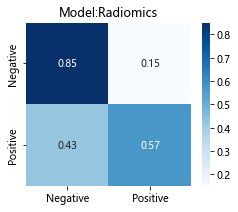

In [31]:
cm_yz2024 = okcomp.comp1.calc_confusion_matrix(y_pred,y_yz2024_data[label],class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Model:Radiomics')
okcomp.comp1.draw_matrix(cm_yz2024, norm=True, annot=True, cmap='Blues')
plt.savefig(f'test_img/Radiomics_test_yz2024.tif', bbox_inches = 'tight',dpi=300)

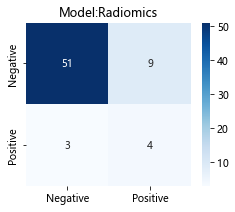

In [32]:
cm_yz2024 = okcomp.comp1.calc_confusion_matrix(y_pred,y_yz2024_data[label],class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Model:Radiomics')
okcomp.comp1.draw_matrix(cm_yz2024, norm=False, annot=True, cmap='Blues')
plt.savefig(f'test_img/Radiomics_test_yz2024_1.tif', bbox_inches = 'tight',dpi=300)

In [20]:
st_file = "./DUKE_recurrect.csv"
data_duke = pd.read_csv(st_file, header=0)
labels_duke = ['label']
featrues_not_use = ['ID']
label_duke_data=data_duke[['ID','label']]

In [21]:
ids_duke = data_duke['ID']
structed_data_duke = data_duke.drop(['ID'], axis=1)
structed_data_duke.columns

Index(['label', 'log-sigma-2-0-mm-3D_firstorder_10Percentile',
       'log-sigma-2-0-mm-3D_firstorder_90Percentile',
       'log-sigma-2-0-mm-3D_firstorder_Energy',
       'log-sigma-2-0-mm-3D_firstorder_Entropy',
       'log-sigma-2-0-mm-3D_firstorder_InterquartileRange',
       'log-sigma-2-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-2-0-mm-3D_firstorder_Maximum',
       'log-sigma-2-0-mm-3D_firstorder_Mean',
       'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation',
       ...
       'wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LLL_glszm_SizeZoneNonUniformity',
       'wavelet-LLL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-LLL_glszm_SmallAreaEmphasis',
       'wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZonePercentage',
       'wavelet-LLL_glszm_ZoneVariance'],
     

In [22]:
from onekey_algo.custom.components.comp1 import normalize_df
data_duke = normalize_df(structed_data_duke, not_norm=labels_duke)
data_duke = data_duke.dropna(axis=1)
data_duke

,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,0,1.187102,0.489545,0.416309,-0.555201,-0.707012,0.082180,0.214217,0.924134,-0.661230,...,-0.616697,-0.614931,0.485351,-0.949683,-0.930039,-0.390663,-0.610780,0.536613,-0.773476,0.415486
1,0,-0.454045,0.634824,-0.297350,1.243566,0.921335,-0.582396,0.055956,0.157804,1.050083,...,0.011485,0.050701,-0.328524,1.341912,1.292091,0.496744,0.057277,0.147071,1.167556,-0.896937
2,0,-1.628021,-0.648352,-0.327736,0.806612,1.554040,-1.118724,-0.960909,-1.217256,1.026610,...,-0.031173,0.006335,-0.349065,1.282079,1.273648,0.419995,0.012730,0.152590,1.328128,-1.101393
3,0,-1.530921,0.078084,-0.314258,1.439131,2.004567,-0.951022,-0.410445,-0.782675,1.510359,...,0.359245,0.404298,-0.336707,1.059083,1.047878,-0.082320,0.409435,0.395591,0.974179,-0.694749
4,0,-1.192609,-1.375815,-0.332616,-0.118076,-0.122961,-0.499978,-0.924727,-1.460039,-0.272220,...,0.038643,0.073757,-0.353574,0.941111,0.959777,-0.448441,0.079126,-0.309253,1.078111,-1.028936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,0,0.263809,-0.152398,-0.307667,-0.557649,-0.614520,-0.548087,-0.688654,0.068821,-0.557341,...,-0.011558,0.020331,-0.350451,0.233194,0.286364,-0.125819,0.025947,-0.216470,0.468986,-0.655749
426,0,-1.669696,-1.895339,-0.361324,-1.044512,0.086484,-1.082223,-1.438883,-2.088248,-0.447396,...,2.773942,2.872959,-0.430033,0.663812,0.672142,-1.499244,2.873058,-2.767679,0.557520,-0.412562
427,0,0.692789,-0.672212,-0.274730,-1.749303,-1.483737,-0.158044,-0.868233,-0.037590,-1.410163,...,-0.055248,-0.122529,-0.324855,-1.742397,-1.813449,-1.666890,-0.128792,-1.436173,-1.898220,2.076116
428,0,0.374003,0.158534,0.190848,0.033785,-0.064922,-0.545170,-0.265194,0.395434,-0.187674,...,-0.624154,-0.614672,0.364715,-0.212187,-0.174763,-0.510037,-0.609282,0.447852,-0.126270,-0.055379


In [23]:
y_duke_data = data_duke[labels]
X_duke_data = data_duke.drop(labels, axis=1)

In [24]:
X_duke_data = X_duke_data[selected_features[0]]
X_duke_data.columns

Index(['original_shape_Maximum2DDiameterColumn', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_ZoneEntropy', 'wavelet-HLL_glcm_Correlation',
       'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis'],
      dtype='object')

In [25]:
import joblib
model_bst=joblib.load('./models/Rad_MLP_label.pkl')
model_bst

MLPClassifier(hidden_layer_sizes=(128, 128, 64), max_iter=1000, random_state=0,
              solver='sgd')

In [26]:
y_duke_score=model_bst.predict_proba(X_duke_data)

In [27]:
y_duke_pred = np.array(y_duke_score[:,-1] >=  0.147410).astype(int)
y_duke_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [28]:
## 预测训练集和测试集数据。
duke_indexes = np.reshape(np.array(ids_duke .loc[list(X_duke_data.index)]), (-1, 1)).astype(str)
# y_xah_pred_scores = target.predict_proba(X_xah_data)
columns = ['ID'] + [f"{label}-{i}"for i in range(y_duke_score.shape[1])]
# 保存预测的训练集和测试集结果
result= pd.DataFrame(np.concatenate([duke_indexes, y_duke_score], axis=1), columns=columns)
result.to_csv(f'test_results/Rad_duke.csv', index=False)

In [22]:
TCGA_file = "./TCGA_rad.csv"
data_TCGA = pd.read_csv(TCGA_file, header=0)
labels_TCGA = ['label']
featrues_not_use = ['ID']
label_TCGA_data=data_TCGA[['ID','label']]

In [23]:
ids_TCGA = data_TCGA['ID']
structed_data_TCGA = data_TCGA.drop(['ID'], axis=1)
structed_data_TCGA.columns

Index(['label', 'log-sigma-2-0-mm-3D_firstorder_10Percentile',
       'log-sigma-2-0-mm-3D_firstorder_90Percentile',
       'log-sigma-2-0-mm-3D_firstorder_Energy',
       'log-sigma-2-0-mm-3D_firstorder_Entropy',
       'log-sigma-2-0-mm-3D_firstorder_InterquartileRange',
       'log-sigma-2-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-2-0-mm-3D_firstorder_Maximum',
       'log-sigma-2-0-mm-3D_firstorder_Mean',
       'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation',
       ...
       'wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LLL_glszm_SizeZoneNonUniformity',
       'wavelet-LLL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-LLL_glszm_SmallAreaEmphasis',
       'wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZonePercentage',
       'wavelet-LLL_glszm_ZoneVariance'],
     

In [24]:
from onekey_algo.custom.components.comp1 import normalize_df
data_TCGA = normalize_df(structed_data_TCGA, not_norm=labels_TCGA)
data_TCGA = data_TCGA.dropna(axis=1)
data_TCGA

,label,log-sigma-2-0-mm-3D_firstorder_10Percentile,log-sigma-2-0-mm-3D_firstorder_90Percentile,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_Entropy,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,log-sigma-2-0-mm-3D_firstorder_Kurtosis,log-sigma-2-0-mm-3D_firstorder_Maximum,log-sigma-2-0-mm-3D_firstorder_Mean,log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,0,-1.929685,-1.350077,-0.434281,0.963287,1.120371,-0.594875,-0.483940,-1.989958,0.885846,...,-0.108659,-0.202942,-0.349640,1.282453,1.243805,0.912051,-0.188873,0.436155,1.129473,-0.142325
1,0,0.722739,-0.653589,-0.346009,-1.202753,-1.174656,-0.488905,-0.893141,0.219000,-1.180114,...,-0.097935,-0.092137,-0.448452,-0.903193,-0.907126,-0.631527,-0.083033,0.152482,-0.981256,-0.035248
2,0,0.622395,1.463699,0.582018,0.470227,0.038328,1.764086,1.207589,0.980522,0.518465,...,-0.113543,-0.319622,0.630500,-0.162793,-0.123494,1.034412,-0.311987,0.952638,-0.052235,-0.095916
3,0,0.603266,-0.074954,-0.149376,-0.554444,-0.748127,-0.215221,-0.208117,0.396818,-0.698890,...,-0.112305,-0.266729,-0.225317,-0.913692,-0.910973,-0.271299,-0.254442,0.125063,-0.998747,-0.012977
4,0,-0.493380,0.522333,-0.356974,0.730188,0.686469,-0.563444,-0.373165,0.344751,0.698787,...,-0.096230,-0.055613,-0.401026,0.781009,0.805255,-0.409944,-0.045019,0.520210,0.907957,-0.142340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0,-0.457283,-0.961178,-0.378462,-0.126259,-0.015411,-0.735046,-1.162377,-0.678767,-0.234492,...,-0.095059,-0.081520,-0.330618,1.186565,1.179917,-0.923677,-0.082109,-0.399780,1.221557,-0.150577
124,0,1.018362,0.091726,0.008013,-0.856199,-0.757467,-0.411381,-0.565248,0.938704,-0.897608,...,-0.076871,0.023144,-0.102965,-1.038063,-1.029724,-1.101011,0.003366,0.248123,-0.851017,-0.058644
125,0,1.493904,0.074106,0.510821,-1.513874,-1.350468,-0.519329,-0.691576,1.169528,-1.381082,...,-0.104912,-0.215510,0.337985,-1.403607,-1.431572,-0.940192,-0.211492,0.491047,-1.270030,-0.027974
126,1,-2.095696,-1.283610,-0.073412,1.131474,1.210178,-0.483165,0.580182,-2.150406,1.079971,...,-0.119330,-0.345822,0.554943,0.898292,0.906692,0.663739,-0.331859,0.864528,0.921510,-0.138806


In [25]:
y_TCGA_data = data_TCGA[labels]
X_TCGA_data = data_TCGA.drop(labels, axis=1)

In [26]:
X_TCGA_data = X_TCGA_data[selected_features[0]]
X_TCGA_data.columns

Index(['original_shape_Maximum2DDiameterColumn', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_ZoneEntropy', 'wavelet-HLL_glcm_Correlation',
       'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis'],
      dtype='object')

In [27]:
import joblib
model_bst=joblib.load('./models/Rad_MLP_label.pkl')
model_bst

MLPClassifier(hidden_layer_sizes=(128, 128, 64), max_iter=1000, random_state=0,
              solver='sgd')

In [28]:
y_TCGA_score=model_bst.predict_proba(X_TCGA_data)

In [29]:
y_TCGA_pred = np.array(y_TCGA_score[:,-1] >=  0.147410).astype(int)
y_TCGA_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [30]:
## 预测训练集和测试集数据。
TCGA_indexes = np.reshape(np.array(ids_TCGA .loc[list(X_TCGA_data.index)]), (-1, 1)).astype(str)
# y_xah_pred_scores = target.predict_proba(X_xah_data)
columns = ['ID'] + [f"{label}-{i}"for i in range(y_TCGA_score.shape[1])]
# 保存预测的训练集和测试集结果
result= pd.DataFrame(np.concatenate([TCGA_indexes, y_TCGA_score], axis=1), columns=columns)
result.to_csv(f'test_results/Pred_TCGA.csv', index=False)